In [13]:
import jax
import jax.numpy as jnp
import numpy as np
from jax import jit, vmap
import matplotlib.pyplot as plt
from functools import partial

In [14]:

def _svd_init(traces):
    U, S, V = jnp.linalg.svd(traces)
    U = U[:, 0:1] * S[0]
    V = V[0:1, :]
    U, V = jax.lax.cond(
        jnp.all(jnp.array([jnp.all(U <= 1e-10), jnp.all(V <= 1e-10)])),
        lambda _: (U * -1, V * -1),
        lambda _: (U, V),
        None
    )
    return U, V
    
@partial(jit, static_argnames=('update_U', 'update_V'))
def _rank_one_nmu(traces, init_factors,
    update_U=True, update_V=True, maxiter=5000, tol=1e-2, rho=2.0,):
    """Non-negative matrix underapproximation with rank 1 using ADMM

    Init factors must be passed as a tuple of U and V matrices, due to the way JAX handles
    optional arguments. If init_factors_contains NaN, override with SVD initialization.

    Parameters
    ----------
    traces : array-like
        Traces to estimate photocurrents from. Shape is (n_traces, n_timepoints).
    init_factors : tuple of array-like
        Initial U and V matrices. Shape is (n_traces, rank) and (rank, n_timepoints).
    update_U : bool
        If True, update U.
    update_V : bool
        If True, update V.
    maxiter : int
        Maximum number of iterations.
    tol : float
        Tolerance for convergence.
    rho : float
        ADMM penalty parameter.
    init_factors : tuple of array-like
        Initial U and V matrices. Shape is (n_traces, rank) and (rank, n_timepoints).
        If None, initialize using SVD.
    """  
    U, V = init_factors
    U, V = jax.lax.cond(
        jnp.any(jnp.isnan(U @ V)),
        lambda _: _svd_init(traces),
        lambda _: init_factors,
        None
    )

    R = jnp.maximum(0, traces - U @ V)
    Gamma = jnp.zeros_like(traces)
    U_old = U.copy() + 10 * tol
    V_old = V.copy() + 10 * tol
    k = 0
    max_violation = jnp.zeros(maxiter) * jnp.nan
    val = (U, V, U_old, V_old, R, Gamma, k, max_violation) 

    def _convergence_tol_check(val):
        U, V, U_old, V_old, R, Gamma, k, max_violation = val
        return jnp.any(jnp.array([
            (jnp.linalg.norm(U - U_old) / jnp.linalg.norm(U_old) > tol),
            (jnp.linalg.norm(V - V_old) / jnp.linalg.norm(V_old) > tol),
            jnp.min(traces - U @ V) < -tol,
        ]))

    def _not_converged(val):
        U, V, U_old, V_old, R, Gamma, k, max_violation = val
        return jax.lax.cond(
            k < maxiter,
            lambda _: _convergence_tol_check(val),
            lambda _: False,
            None
        )

    def _update(val):
        U, V, U_old, V_old, R, Gamma, k, max_violation = val
        U_old = U.copy()
        V_old = V.copy()
        M = traces - R + Gamma / rho
        resid = traces - U @ V
        if update_U:
            U = M @ V.T
            U = jnp.maximum(0, U)
            U = jax.lax.cond(
                jnp.all(U <= 1e-10),
                lambda _: U * 0.0,
                lambda _: U / jnp.linalg.norm(U),
                None,
            )
        if update_V:
            V = (U.T @ M) / (U.T @ U + 1e-10)
            V = jnp.maximum(0, V)
        R = 1 / (1 + rho) * (rho * resid + Gamma)
        R = jnp.maximum(0, R)
        Gamma = Gamma + rho * (resid - R)
        max_violation = max_violation.at[k].set(jnp.min(traces - U @ V))
        k += 1
        return (U, V, U_old, V_old, R, Gamma, k, max_violation)
    val = jax.lax.while_loop(
        _not_converged,
        _update,
        val,
    )
    (U, V, U_old, V_old, R, Gamma, k, max_violation) = val

    return U, V, max_violation


@partial(jit, static_argnames=('update_U', 'update_V'))
def _nmu(traces, init_factors, update_U=True, update_V=True, rank=1, **admm_kwargs):
    """Non-negative matrix underapproximation, solved recursively by updating rank-1 factors.

    Parameters
    ----------
    traces : array-like
        Traces to estimate photocurrents from. Shape is (n_traces, n_timepoints).
    init_factors : tuple of array-like
        Initial U and V matrices. Shape is (n_traces, rank) and (rank, n_timepoints).
        Pass in all NaN to use SVD init in the inner loop.
    rank : int
        Rank of the estimated matrix.
    update_U : bool
        If True, update U.
    update_V : bool 
        If True, update V.
    init_factors : tuple of array-like
        Initial U and V matrices. Shape is (n_traces, rank) and (rank, n_timepoints).

    Returns
    -------
    U : array-like
        Estimated U matrix. Shape is (n_traces, rank).
    V : array-like
        Estimated V matrix. Shape is (rank, n_timepoints).
    """
    U, V = init_factors
    N, rank = U.shape

    # The call to jax.lax.scan is equivalent to this:
    # for i in range(rank):
    #     U_i, V_i, _ = _rank_one_nmu(
    #         traces,
    #         (U[:, i:i+1], V[i:i+1, :]),
    #         update_U=update_U,
    #         update_V=update_V,
    #         **admm_kwargs,
    #     )
    #     U = U.at[:, i:i+1].set(U_i)
    #     V = V.at[i:i+1, :].set(V_i)
    #     traces = traces - U_i @ V_i

    def _scan_inner(val, curr_init_factors):
        traces = val
        U_i, V_i, _ = _rank_one_nmu(
            traces,
            curr_init_factors,
            update_U=update_U,
            update_V=update_V,
            **admm_kwargs,
        )
        traces = traces - U_i @ V_i
        return traces, (U_i, V_i)
    _, stacked_factors = jax.lax.scan(
        _scan_inner,
        traces,
        (U, V),
    )
    return stacked_factors

@partial(jit, static_argnames=('constrain_V', 'rank', 'stim_start', 'stim_end'))
def estimate_photocurrents_nmu(traces, stim_start=100, stim_end=200, constrain_V=False, rank=1):
    """Estimate photocurrents using non-negative matrix underapproximation.

    Parameters
    ----------
    traces : array-like
        Traces to estimate photocurrents from. Shape is (n_traces, n_timepoints).
    stim_start : int
        Index of first timepoint of stimulus.
    stim_end : int
        Index of last timepoint of stimulus.
    constrain_V : bool
        If True, constrain the estimated V using the underapprox constraint.
    rank : int
        Rank of the estimated matrix.

    Returns
    -------
    U : array-like
        Estimated U matrix. Shape is (n_traces, rank).
    V : array-like
        Estimated V matrix. Shape is (rank, n_timepoints).
    """
    # Create dummy initial factors
    # to use SVD initialization inside _rank_one_nmu
    U_init = jnp.zeros((traces.shape[0], rank)) * jnp.nan
    V_init = jnp.zeros((rank, stim_end - stim_start)) * jnp.nan
    traces = jnp.maximum(0, traces)
    U_stim, V_stim = _nmu(traces[:, stim_start:stim_end], (U_init, V_init), 
        rank=rank, update_U=True, update_V=True)
    V_full = jnp.linalg.lstsq(U_stim, traces)[0]
    if constrain_V:
        _, V_full = _nmu(traces, rank=rank, init_factors=(U_stim, V_full), update_U=False, update_V=True)
    return U_stim, V_full

def estimate_photocurrents_by_batches(traces,
                           rank=1, constrain_V=True,
                           stim_start=100, stim_end=200, batch_size=-1):

    def _make_estimate(pscs, stim_start=100, stim_end=200):
        U, V = estimate_photocurrents_nmu(
            pscs,
            rank=rank,
            stim_start=stim_start,
            stim_end=stim_end,
            constrain_V=constrain_V
        )
        return U @ V

    def _make_estimate_batched(pscs, stim_start, stim_end):
        return jit(vmap(
            partial(_make_estimate, stim_start=stim_start, stim_end=stim_end),
        ))(pscs)

    # sort traces by magnitude around stim
    idxs = np.argsort(np.linalg.norm(
        traces[:, stim_start:stim_end+50], axis=-1))

    # save this so that we can return estimates in the original (unsorted) order
    reverse_idxs = np.argsort(idxs)
    traces = traces[idxs]

    if batch_size == -1:
        est = _make_estimate(
            traces, stim_start, stim_end
        )
    else:
        est = np.zeros_like(traces)
        num_complete_batches = traces.shape[0] // batch_size
        max_index = num_complete_batches * batch_size
        folded_traces = traces[:max_index].reshape(
            num_complete_batches, batch_size, traces.shape[1])
        
        # take advantage of vmap to run in parallel on all batches (except the last one)
        ests_batched = _make_estimate_batched(folded_traces, stim_start, stim_end)
        print('got here')
        # est[:max_index] = np.concatenate(
        #     [_make_estimate(x, stim_start, stim_end) for x in folded_traces], axis=0)

        # re-run on last batch, in case the number of traces is not divisible by the batch size
        if traces.shape[0] % batch_size != 0:
            est[-batch_size:] = _make_estimate(traces[-batch_size:],
                                               stim_start, stim_end)

    est = est[reverse_idxs]
    return est

In [4]:
import subtractr.utils as utils

pscs, stim_mat, powers, targets = utils.load_h5_data('../data/masato/B6WT_AAV_hsyn_chrome2f_gcamp8/preprocessed/220308_B6_Chrome2fGC8_030822_Cell2_opsPositive_A_planes_cmReformat.mat')
idxs = np.argsort(pscs[:, 100:250].sum(axis=1))[::-1]
sorted_pscs = pscs[idxs]
first_batch = sorted_pscs[:100]
truncated_pscs = np.maximum(first_batch, 0)

In [15]:
U, V = estimate_photocurrents_nmu(truncated_pscs, rank=1, constrain_V=True)

IndexError: Array slice indices must have static start/stop/step to be used with NumPy indexing syntax. Found slice(Traced<ShapedArray(int64[], weak_type=True)>with<DynamicJaxprTrace(level=1/2)>, Traced<ShapedArray(int64[], weak_type=True)>with<DynamicJaxprTrace(level=1/2)>, None). To index a statically sized array at a dynamic position, try lax.dynamic_slice/dynamic_update_slice (JAX does not support dynamically sized arrays within JIT compiled functions).

In [11]:
rank = 2

est = estimate_photocurrents_by_batches(pscs, rank=rank, constrain_V=True, stim_start=100, stim_end=200, batch_size=100)
# plt.plot((pscs - est).T)


got here


TypeError: true_fun and false_fun output must have identical types, got
('DIFFERENT ShapedArray(float64[100,1]) vs. ShapedArray(float64[100,2])', 'DIFFERENT ShapedArray(float64[1,100]) vs. ShapedArray(float64[2,100])').

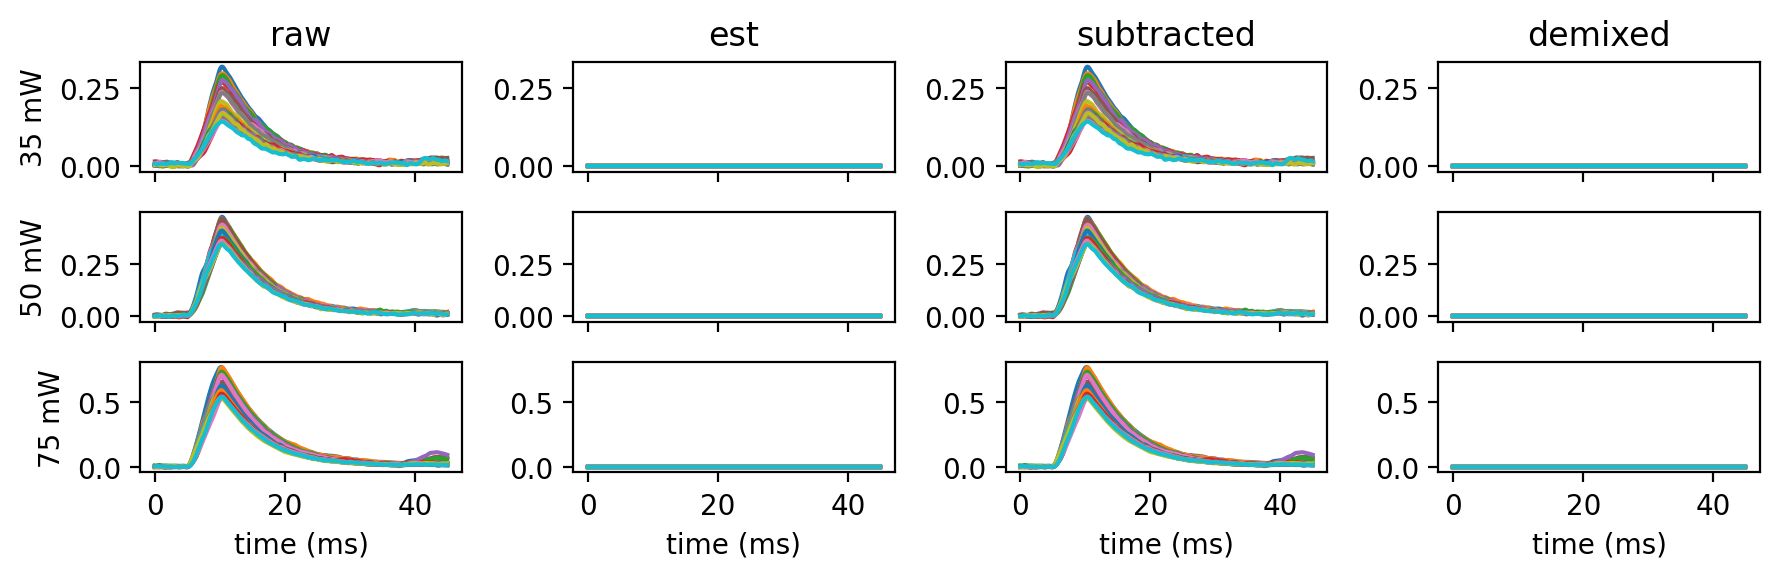

In [6]:
fig = utils.plot_subtraction_by_power(
        pscs,
        est,
        pscs - est,
        np.zeros_like(pscs),
        powers,
    )

DeviceArray(-0.05201871, dtype=float64)

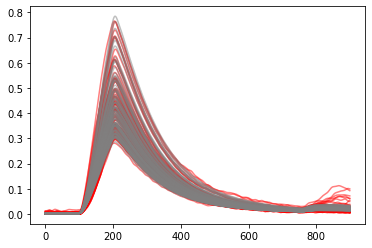

In [118]:
U_nmf, S_nmf, V_nmf = jnp.linalg.svd(truncated_pscs)
U_nmf = U_nmf[:, 0:1] * S_nmf[0]
V_nmf = V_nmf[0:1, :]

nmf_est = U_nmf @ V_nmf
plt.plot(truncated_pscs.T, color='red', alpha=0.5)
plt.plot(nmf_est.T, color='grey', alpha=0.5)
jnp.min(truncated_pscs - nmf_est)

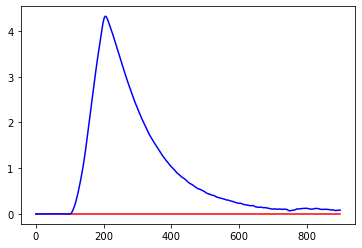

In [119]:
plt.plot(V[0, :], color='red')
plt.plot(V[1, :], color='blue')